# Sistema de recomendação em tempo real
#### Modelo de recomendação com Machine Learning, PySpark, Spark Streaming e Kafka com dados do Spotify.

*by [Bruno Azambuja](https://www.linkedin.com/in/brunoazambuja/)*


## Business problem

Neste projeto implementarei um sistema de recomendação em tempo real. Vamos recomendar músicas do Spotify de acordo com as preferências do usuários, mas o projeto pode ser modificado para recomendar outros produtos ou serviços. Este  projeto é composto de diversas partes uma vez que toda a infraestrutura necessária será construída passo a passo.

Cada usuário tem suas preferências musicais e neste projeto recomendaremos novas músicas de acordo com as preferências do usuário. De fato, é exatamente isso que a Spotify faz com  os  usuários  da  sua  app,  para  que  os  usuários  assinem  o  serviço  pago  da empresa  ou mantenham o plano existente.

Usaremos 2 streams de dados:

- Stream 1: Usaremos um  dataset com milhares de  músicas. A partir desse dataset que recomendaremos as músicas para o usuário. Vamos utilizar o dataset que foi extraído no link: https://research.atspotify.com/datasets;

- Stream 2: Vamos extrair as preferências musicais do usuário direto do Spotify com a  API  gratuita  fornecida  pela  empresa. Teremos que criar uma conta  gratuita no Spotify, pesquisar algumas das músicas ou artistas preferidos e dar um like em algumas músicas para gerar uma massa de dados. Vamos extrair as preferências e construir o sistema de recomendação.


In [ ]:
# Instalando pacotes
!pip install -q -U watermark
!pip install findspark
!pip install -q spotipy
!pip install -q kafka-python

In [ ]:
# Importando pacotes
import os
import time
import random
import pyspark
import ujson
import spotipy
import spotipy.util
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import kafka
from platform import python_version
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.ml.feature import Normalizer, StandardScaler
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler
from tqdm import tqdm
from json import dumps
from kafka import KafkaProducer
warnings.filterwarnings("ignore")

In [ ]:
# Versão da linguagem Python
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.9.13


## Criando um Kafka Producer em linguagem Python

In [ ]:
# Endereço do servidor Kafka
SERVER = 'localhost:9092'

In [ ]:
# Nome do tópico
TOPIC = "projeto"

In [ ]:
# Carregamos o conjunto de dados de músicas
df_projeto = pd.read_csv("dados/dataset.csv")

In [ ]:
# Ajustamos o formato de 3 colunas importantes: order_id, Artist Name(s) e Artist IDs
df_projeto['order_id'] = np.arange(len(df_projeto))
df_projeto['Artist Name(s)'] = df_projeto['Artist Name(s)'].str.replace('[^a-zA-Z]', '')
df_projeto['Artist IDs'] = df_projeto['Artist IDs'].str.replace('[^a-zA-Z]', '')

In [ ]:
# Formatado do dataframe
df_projeto.shape

(4399, 24)

In [ ]:
# Visualizamos os dados
df_projeto.head(10)

,Spotify ID,Artist IDs,Track Name,Album Name,Artist Name(s),Release Date,Duration (ms),Popularity,Added By,Added At,...,Loudness,Mode,Speechiness,Acousticness,Instrumentalness,Liveness,Valence,Tempo,Time Signature,order_id
0,22a0Ji6EQKkY0tBohlN4Od,qLyYYhSlsjwymwVKwW,There You Are,There You Are,KirstenLudwig,2018-08-06,231240,2,spotify:user:predict0,2018-08-28T19:51:58Z,...,-5.596,0,0.0304,0.334000,0.282000,0.1050,0.316,129.856,4,0
1,4J39ZEbwqHwtWLImUKmrn9,CRfAxYjJsDBHwvWFnjaRRRPXwFwQmoTNqNHBGU,88 Days,Heat,SaraKingIanOlney,2018-08-04,227961,8,spotify:user:predict0,2018-08-28T19:51:58Z,...,-10.749,1,0.0333,0.134000,0.582000,0.1340,0.233,155.062,4,1
2,0a12d4HUjOmQSqHqLopWYx,hytHTGTflktWAhKcxQ,Castaway,Castaway,ARZLEE,2018-08-10,230000,0,spotify:user:predict0,2018-08-28T19:51:58Z,...,-11.290,1,0.0314,0.110000,0.000032,0.1190,0.290,83.988,4,2
3,4u1DykFW1HjYAGNoDCiXfC,WjyoJHRHlTbUTZTwqpAgeqmtJlARXjon,Arouse,Arouse,Shagabondgoodboynoah,2018-08-03,213913,30,spotify:user:predict0,2018-08-28T19:51:58Z,...,-6.066,1,0.4330,0.072800,0.000000,0.3680,0.533,91.961,4,3
4,0u7JZm9ORerlZnnxxSdMwl,AdKmjgFzpcTvmVfGwR,Lonely,Lonely,Hayleau,2018-08-10,258738,21,spotify:user:predict0,2018-08-28T19:51:58Z,...,-3.921,0,0.0406,0.016900,0.000630,0.0542,0.577,98.954,4,4
5,0wuy2BYIVLbflFDqnR9Jay,kCwrYUFSJCubbbnZrE,Orsay,Strange Affairs,TheSvens,2018-08-03,413658,6,spotify:user:predict0,2018-08-28T19:51:58Z,...,-11.858,1,0.0316,0.048600,0.886000,0.1280,0.283,122.992,4,5
6,6LkIZZRrPQIbHMyBR5mTc2,TOsWuafqeWtrvYXqbnYAV,Nurture,Comrade,IslandFox,2018-08-09,191641,0,spotify:user:predict0,2018-08-28T19:51:58Z,...,-11.415,0,0.0504,0.015900,0.639000,0.1810,0.266,133.925,4,6
7,5U27fxNSd27XtX876xUsfV,HsKUExgNcRJojPmBcNqzgwpvzedAIjuDBM,Dinosaur Hair - Remix,Dinosaur Hair,AndyFerroCharlieConway,2018-08-10,257152,1,spotify:user:predict0,2018-08-28T19:51:58Z,...,-10.086,1,0.0383,0.456000,0.920000,0.1350,0.663,125.908,4,7
8,5ogJOpmyDsvrAdttU6JLnN,gslbnQQLLcNzfjnxQY,Breathing Underwater,Long Way Down,MorningWars,2018-08-03,174999,0,spotify:user:predict0,2018-08-28T19:51:58Z,...,-11.258,0,0.0461,0.000005,0.020400,0.1150,0.477,150.042,4,8
9,65rLHt6A58MFRxlNWVDU1Z,WlYiRrlrChWktQDo,Summer,Summer,NoSo,2018-08-01,232746,22,spotify:user:predict0,2018-08-28T19:51:58Z,...,-7.517,1,0.0380,0.016800,0.007230,0.0706,0.210,123.962,4,9


In [ ]:
# Convertemos o dataframe em um dicionário de músicas
dict_musicas = df_projeto.to_dict(orient = "records")

In [ ]:
# Verificamos o dicionário dos dados
dict_musicas[1:3]

[{'Spotify ID': '4J39ZEbwqHwtWLImUKmrn9',
  'Artist IDs': 'CRfAxYjJsDBHwvWFnjaRRRPXwFwQmoTNqNHBGU',
  'Track Name': '88 Days',
  'Album Name': 'Heat',
  'Artist Name(s)': 'SaraKingIanOlney',
  'Release Date': '2018-08-04',
  'Duration (ms)': 227961,
  'Popularity': 8,
  'Added By': 'spotify:user:predict0',
  'Added At': '2018-08-28T19:51:58Z',
  'Genres': 'bedroom pop',
  'Danceability': 0.335,
  'Energy': 0.401,
  'Key': 3,
  'Loudness': -10.749,
  'Mode': 1,
  'Speechiness': 0.0333,
  'Acousticness': 0.134,
  'Instrumentalness': 0.582,
  'Liveness': 0.134,
  'Valence': 0.233,
  'Tempo': 155.062,
  'Time Signature': 4,
  'order_id': 1},
 {'Spotify ID': '0a12d4HUjOmQSqHqLopWYx',
  'Artist IDs': 'hytHTGTflktWAhKcxQ',
  'Track Name': 'Castaway',
  'Album Name': 'Castaway',
  'Artist Name(s)': 'ARZLEE',
  'Release Date': '2018-08-10',
  'Duration (ms)': 230000,
  'Popularity': 0,
  'Added By': 'spotify:user:predict0',
  'Added At': '2018-08-28T19:51:58Z',
  'Genres': nan,
  'Danceability'

In [ ]:
# Kafka Producer
if __name__ == "__main__":

    # Cria o producer
    producer = KafkaProducer(bootstrap_servers = SERVER,
                             value_serializer = lambda x: x.encode('utf-8'))

    # Variáveis de controle
    send = []
    send = None

    # Loop pelo dicionário de músicas
    for musica in dict_musicas:

        # Cria a lista com dados que serão enviados para o Kafka
        sending = []

        # Append de cada coluna
        sending.append(musica["order_id"])
        sending.append(musica["Spotify ID"])
        sending.append(musica["Track Name"])
        sending.append(musica["Popularity"])
        sending.append(musica["Duration (ms)"])
        sending.append(musica["Artist Name(s)"])
        sending.append(musica["Artist IDs"])
        sending.append(musica["Release Date"])
        sending.append(musica["Danceability"])
        sending.append(musica["Energy"])
        sending.append(musica["Key"])
        sending.append(musica["Loudness"])
        sending.append(musica["Mode"])
        sending.append(musica["Speechiness"])
        sending.append(musica["Acousticness"])
        sending.append(musica["Instrumentalness"])
        sending.append(musica["Liveness"])
        sending.append(musica["Valence"])
        sending.append(musica["Tempo"])
        sending.append(musica["Time Signature"])

        # Junta tudo
        musica = ','.join(str(v) for v in sending)

        # Envia os dados para o tópico
        print("Próxima Música:" )
        print(musica)
        producer.send(TOPIC, musica)
        time.sleep(1)

    print("Concluído")

## Stream 1: Extração de dados em tempo real com Spark

In [ ]:
# Endereço do servidor Kafka
SERVER = 'localhost:9092'

In [ ]:
# Nome do tópico
TOPIC = "projeto"

In [ ]:
# Conectores do Spark para o Apache Kafka
spark_jars =  ("{},{},{},{},{}".format(os.getcwd() + "/jars/spark-sql-kafka-0-10_2.12-3.2.1.jar",
                                       os.getcwd() + "/jars/kafka-clients-2.1.1.jar",
                                       os.getcwd() + "/jars/spark-streaming-kafka-0-10-assembly_2.12-3.3.2.jar",
                                       os.getcwd() + "/jars/commons-pool2-2.8.0.jar",
                                       os.getcwd() + "/jars/spark-token-provider-kafka-0-10_2.12-3.1.2.jar"))

In [ ]:
# Inicializa sessão Spark
spark = SparkSession \
        .builder \
        .config("spark.jars", spark_jars) \
        .appName("mini_projeto") \
        .getOrCreate()

23/07/15 16:11:56 WARN Utils: Your hostname, DESKTOP resolves to a loopback address: 127.0.1.1; using 172.26.138.20 instead (on interface eth0)
23/07/15 16:11:57 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
23/07/15 16:12:00 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


In [ ]:
# Filtra somente avisos de error
spark.sparkContext.setLogLevel("ERROR")

In [ ]:
# Usamos o Spark Streaming para leitura do streaming de dados do Kafka e salvamos em um dataframe
df = spark \
        .readStream \
        .format("kafka") \
        .option("kafka.bootstrap.servers", SERVER) \
        .option("subscribe", TOPIC) \
        .option("startingOffsets", "latest") \
        .load()

In [ ]:
# Selecionamos a coluna timestamp como string e salvamos em um novo dataframe
df1 = df.selectExpr("CAST(value AS STRING)", "timestamp")

In [ ]:
# Definimos o schema com o nome de cada coluna e o tipo de dado
def_schema = "order_id INT, id STRING, name STRING, popularity INT, duration_ms DOUBLE, " \
             + "artists STRING, id_artists STRING, release_date STRING, " \
             + "danceability DOUBLE,energy DOUBLE, key INT, loudness DOUBLE, " \
             + "mode INT,speechiness DOUBLE," \
             + "acousticness DOUBLE, instrumentalness DOUBLE, liveness DOUBLE, " \
             + "valence DOUBLE, tempo DOUBLE, time_signature DOUBLE"

In [ ]:
# Selecionamos o streaming de dados de acordo com o schema e salvamos em um novo dataframe
df2 = df1.select(from_csv(col("value"), def_schema).alias("song"), "timestamp")

In [ ]:
# Criamos uma view na memória do Spark e visualizamos o schema
df3 = df2.select("song.*", "timestamp")
df3.createOrReplaceTempView("df3_View");
df3.printSchema()

root
 |-- order_id: integer (nullable = true)
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- popularity: integer (nullable = true)
 |-- duration_ms: double (nullable = true)
 |-- artists: string (nullable = true)
 |-- id_artists: string (nullable = true)
 |-- release_date: string (nullable = true)
 |-- danceability: double (nullable = true)
 |-- energy: double (nullable = true)
 |-- key: integer (nullable = true)
 |-- loudness: double (nullable = true)
 |-- mode: integer (nullable = true)
 |-- speechiness: double (nullable = true)
 |-- acousticness: double (nullable = true)
 |-- instrumentalness: double (nullable = true)
 |-- liveness: double (nullable = true)
 |-- valence: double (nullable = true)
 |-- tempo: double (nullable = true)
 |-- time_signature: double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [ ]:
# Selecionamos os dados com as músicas do stream
musicas_stream = spark.sql("SELECT * FROM df3_View")

In [ ]:
# Não podemos visualizar ainda, pois temos que gerar o stream do Spark Streaming
# musicas_stream.show()

In [ ]:
# Criamos o stream de dados no Spark Streaming
musicas_stream_spark = musicas_stream \
        .writeStream \
        .trigger(processingTime = '5 seconds') \
        .outputMode("append") \
        .option("truncate", "false") \
        .format("memory") \
        .queryName("tabela_spark") \
        .start()

musicas_stream_spark.awaitTermination(1)

False

In [ ]:
# Selecionamos as músicas da tabela de stream do Spark
spark_songs = spark.sql("SELECT * FROM tabela_spark")

In [ ]:
# Agora sim podemos visualizar o stream em tempo real como tabela do Spark
spark_songs.show(5)

+--------+--------------------+-----------------+----------+-----------+------------+--------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+--------------------+
|order_id|                  id|             name|popularity|duration_ms|     artists|          id_artists|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|           timestamp|
+--------+--------------------+-----------------+----------+-----------+------------+--------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+--------------------+
|    1504|0eZc30Bn99wP31p2c...|Californian Light|         0|   253746.0|   Childhood| UGBaLizWYmJGOPlPXra|  2017-04-27|        0.49| 0.754|  7|  -8.374|   0|      0.044|      0.0766|         8.43E-5|   0.158|  0.741| 

In [ ]:
# Podemos visualizar apenas algumas colunas, por exemplo
spark_songs.select('order_id', 'id', 'name', 'popularity', 'duration_ms', 'artists').show(5)

+--------+--------------------+-----------------+----------+-----------+------------+
|order_id|                  id|             name|popularity|duration_ms|     artists|
+--------+--------------------+-----------------+----------+-----------+------------+
|    1504|0eZc30Bn99wP31p2c...|Californian Light|         0|   253746.0|   Childhood|
|    1505|6dJ2A0caAl2wI1sO8...|       Dusty Eyes|         0|   277773.0|    Bedouine|
|    1506|0rQOpOeqsk1ob18EV...|             Rain|         0|   174265.0|       Jonti|
|    1507|4qdUMyUHC8lK3RTrr...|     Pull Me Down|         0|   206000.0|GarrisonCade|
|    1508|53ljs2USVfiTycJO2...|          Funeral|         8|   202909.0|      Reaper|
+--------+--------------------+-----------------+----------+-----------+------------+
only showing top 5 rows



In [ ]:
# Contagem de músicas extraídas em tempo real
spark_songs.count()

713

In [ ]:
# Verificamos a descrição dos dados
spark_songs.describe()

DataFrame[summary: string, order_id: string, id: string, name: string, popularity: string, duration_ms: string, artists: string, id_artists: string, release_date: string, danceability: string, energy: string, key: string, loudness: string, mode: string, speechiness: string, acousticness: string, instrumentalness: string, liveness: string, valence: string, tempo: string, time_signature: string]

Aguarde alguns minutos antes de seguir com a execução para que o streaming de dados possa ser coletado.

## Stream 2: Extração das preferências de usuário na API do Spotify

> Vamos agora trabalhar na extração de dados do Spotify.

Leia o manual em pdf no Capítulo 16 do curso com os detalhes sobre a criação da API.

In [ ]:
# Aqui colocamos as chaves de usário da API do Spotify
os.environ["SPOTIPY_CLIENT_ID"] = 'XXXXXXXXXXXXXXXXXX'
os.environ["SPOTIPY_CLIENT_SECRET"] = 'XXXXXXXXXXXXXXXXXXX'
os.environ["SPOTIPY_REDIRECT_URI"] = 'http://localhost:7777/callback'

https://developer.spotify.com/documentation/general/guides/authorization/scopes/

In [ ]:
# Escopo de extração das preferências do usuário
scope = 'user-library-read'

In [ ]:
# Username no Spotify
username = 'XXXXXXXXXXXXXXXXXX'

In [ ]:
# Criação do token de acesso
token = spotipy.util.prompt_for_user_token(username, scope)

In [ ]:
# Cria o objeto de autenticação
spotipy_obj = spotipy.Spotify(auth = token)

In [ ]:
# Extrai até 50 músicas da lista de favoritos do usuário
saved_tracks = spotipy_obj.current_user_saved_tracks(limit = 50)

In [ ]:
# Número de músicas extraídas
n_tracks = saved_tracks['total']
print('Total de Tracks: %d ' % n_tracks)

Total de Tracks: 50 


In [ ]:
# Função para extrair os atributos da lista de músicas do usuário
def select_features(track_response):
    return {
        'id': str(track_response['track']['id']),
        'name': str(track_response['track']['name']),
        'artists': [artist['name'] for artist in track_response['track']['artists']],
        'popularity': track_response['track']['popularity']
    }

In [ ]:
# Aplica a função
tracks = [select_features(track) for track in saved_tracks['items']]

In [ ]:
# Extrai os atributos das músicas preferidas do usuário
while saved_tracks['next']:
    saved_tracks = spotipy_obj.next(saved_tracks)
    tracks.extend([select_features(track) for track in saved_tracks['items']])

In [ ]:
# Criamos o dataframe do pandas
df_tracks = pd.DataFrame(tracks)
pd.set_option('display.max_rows', len(tracks))
df_tracks['artists'] = df_tracks['artists'].apply(lambda artists: artists[0])

In [ ]:
df_tracks.head(10)

,id,name,artists,popularity
0,2TFch6xh4f0tMf7F6whQYE,Ancora qui,Elisa,0
1,5519RhpzObr9Mn3iqoeodJ,Come and Get Your Love,Redbone,60
2,6PvMYScgXixWYc4I0IXJoS,I've Got to Find the Right Woman - Single Version,Redbone,48
3,76pllrWpfiCoLGhijQBYhO,You Are My Sunshine,Johnny Cash,59
4,5XVb0qfmmkmmsyy7j8oObk,The Rubberband Man,The Spinners,50
5,1TfqLAPs4K3s2rJMoCokcS,Sweet Dreams (Are Made of This) - Remastered,Eurythmics,86
6,70LcF31zb1H0PyJoS1Sx1r,Creep,Radiohead,90
7,3YfS47QufnLDFA71FUsgCM,The Sound of Silence,Simon & Garfunkel,65
8,799oYLpNweNgR4imeuEPn9,Just The Way You Are,Barry White,33
9,5pztwVl6brVgqYjYQ93us6,Stand by Me,Seal,63


In [ ]:
# Dicionário para os atributos de áudio
audio_features = {}

In [ ]:
# Extrai os atributos de áudio
for idd in df_tracks['id'].tolist():
    audio_features[idd] = spotipy_obj.audio_features(idd)[0]

In [ ]:
# Adicionamos os atributos de áudio ao dataframe
df_tracks['acousticness'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['acousticness'])
df_tracks['speechiness'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['speechiness'])
df_tracks['key'] = df_tracks['id'].apply(lambda idd: str(audio_features[idd]['key']))
df_tracks['liveness'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['liveness'])
df_tracks['instrumentalness'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['instrumentalness'])
df_tracks['energy'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['energy'])
df_tracks['tempo'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['tempo'])
df_tracks['loudness'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['loudness'])
df_tracks['danceability'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['danceability'])
df_tracks['valence'] = df_tracks['id'].apply(lambda idd: audio_features[idd]['valence'])

In [ ]:
# Verificamos os dados
df_tracks.head()

,id,name,artists,popularity,acousticness,speechiness,key,liveness,instrumentalness,energy,tempo,loudness,danceability,valence
0,2TFch6xh4f0tMf7F6whQYE,Ancora qui,Elisa,0,0.8250,0.0331,9,0.0978,0.007800,0.329,74.041,-9.193,0.244,0.214
1,5519RhpzObr9Mn3iqoeodJ,Come and Get Your Love,Redbone,60,0.1270,0.0535,11,0.0764,0.000079,0.785,105.543,-6.126,0.674,0.853
2,6PvMYScgXixWYc4I0IXJoS,I've Got to Find the Right Woman - Single Version,Redbone,48,0.0927,0.0305,11,0.1200,0.000000,0.842,102.684,-5.750,0.554,0.962
3,76pllrWpfiCoLGhijQBYhO,You Are My Sunshine,Johnny Cash,59,0.8420,0.0893,9,0.5290,0.000001,0.257,89.787,-15.478,0.421,0.560
4,5XVb0qfmmkmmsyy7j8oObk,The Rubberband Man,The Spinners,50,0.4140,0.0555,10,0.0943,0.000152,0.611,97.264,-9.795,0.821,0.960


In [ ]:
# Selecionamos uma música randomicamente
musica_randomica = random. randint(0,len(df_tracks)-1)
df_musica_randomica = df_tracks.head(musica_randomica)[-1:]
df_musica_randomica

,id,name,artists,popularity,acousticness,speechiness,key,liveness,instrumentalness,energy,tempo,loudness,danceability,valence
45,7ymjj8XtifcKzdebJ5uJBk,Just Breathe - acoustic at home,Eddie Vedder,49,0.732,0.0279,0,0.111,0.0,0.33,106.921,-10.638,0.431,0.389


In [ ]:
# Músicas do streaming do Spark
spark_songs.show(5)

+--------+--------------------+-----------------+----------+-----------+------------+--------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+--------------------+
|order_id|                  id|             name|popularity|duration_ms|     artists|          id_artists|release_date|danceability|energy|key|loudness|mode|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|time_signature|           timestamp|
+--------+--------------------+-----------------+----------+-----------+------------+--------------------+------------+------------+------+---+--------+----+-----------+------------+----------------+--------+-------+-------+--------------+--------------------+
|    1504|0eZc30Bn99wP31p2c...|Californian Light|         0|   253746.0|   Childhood| UGBaLizWYmJGOPlPXra|  2017-04-27|        0.49| 0.754|  7|  -8.374|   0|      0.044|      0.0766|         8.43E-5|   0.158|  0.741| 

In [ ]:
# Não precisamos mais dessas colunas
spark_songs = spark_songs.drop('order_id',
                               'mode',
                               'release_date',
                               'id_artists',
                               'time_signature',
                               'duration_ms',
                               'timestamp')

In [ ]:
# Cria o dataframe com a música escolhida randomicamente
df_sp = spark.createDataFrame(df_musica_randomica)

In [ ]:
# Concatena músicas do streaming do Spark com a música do Spotify
df = spark_songs.union(df_sp)

In [ ]:
# Visualizamos os dados
df.show(5)

+--------------------+-----------------+----------+------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+
|                  id|             name|popularity|     artists|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|
+--------------------+-----------------+----------+------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+
|0eZc30Bn99wP31p2c...|Californian Light|         0|   Childhood|        0.49| 0.754|  7|  -8.374|      0.044|      0.0766|         8.43E-5|   0.158|  0.741| 94.451|
|6dJ2A0caAl2wI1sO8...|       Dusty Eyes|         0|    Bedouine|       0.522| 0.279|  4|  -11.82|      0.027|       0.592|         0.00539|   0.183|  0.381|118.952|
|0rQOpOeqsk1ob18EV...|             Rain|         0|       Jonti|       0.406| 0.707|  4|  -8.987|     0.0583|      0.0324|          0.0259|   0.103|  0.372|170.088|
|4qdUMyUHC

## Pré-processamento dos dados

In [ ]:
# Preparamos o VectorAssembler
vetor = VectorAssembler(inputCols = ['danceability',
                                     'energy',
                                     'loudness',
                                     'speechiness',
                                     'acousticness',
                                     'instrumentalness',
                                     'liveness',
                                     'valence',
                                     'tempo'],
                        outputCol = 'song_features')

In [ ]:
# Descartamos valores inválidos
assembled = vetor.setHandleInvalid("skip").transform(df)

In [ ]:
# Preparamos o padronizador
std = StandardScaler(inputCol = 'song_features', outputCol = 'standardized')

In [ ]:
# Treinamos o padronizador
scale = std.fit(assembled)

In [ ]:
# Dataframe com dados padronizados
df = scale.transform(assembled)

In [ ]:
# Visualizamos os dados
df.show(5)

+--------------------+-----------------+----------+------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+
|                  id|             name|popularity|     artists|danceability|energy|key|loudness|speechiness|acousticness|instrumentalness|liveness|valence|  tempo|       song_features|        standardized|
+--------------------+-----------------+----------+------------+------------+------+---+--------+-----------+------------+----------------+--------+-------+-------+--------------------+--------------------+
|0eZc30Bn99wP31p2c...|Californian Light|         0|   Childhood|        0.49| 0.754|  7|  -8.374|      0.044|      0.0766|         8.43E-5|   0.158|  0.741| 94.451|[0.49,0.754,-8.37...|[2.88385601753006...|
|6dJ2A0caAl2wI1sO8...|       Dusty Eyes|         0|    Bedouine|       0.522| 0.279|  4|  -11.82|      0.027|       0.592|         0.00539|   0.183|  0.381|118.952|[0.522,0

## Machine learning com aprendizado não supervisionado

In [ ]:
# Silhouette Score para diversos números de clusters
silhouette_score=[]

evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='standardized', \
                                metricName='silhouette',
                                distanceMeasure='squaredEuclidean')

for i in range(2,10):
    kmeans=KMeans(featuresCol='standardized', k=i)
    model=kmeans.fit(df)
    predictions=model.transform(df)
    score=evaluator.evaluate(predictions)
    silhouette_score.append(score)
    print('Silhouette Score for k =',i,'is',score)

Silhouette Score for k = 2 is 0.3987711287521007
Silhouette Score for k = 3 is 0.29466179589139024
Silhouette Score for k = 4 is 0.3578877031006484
Silhouette Score for k = 5 is 0.28471238797904536
Silhouette Score for k = 6 is 0.29143583216779256
Silhouette Score for k = 7 is 0.2649470319212026
Silhouette Score for k = 8 is 0.2724590898304979
Silhouette Score for k = 9 is 0.24745862839211527


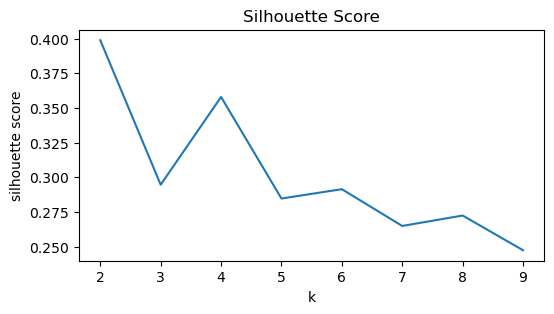

In [ ]:
# Plotamos os silhouettes scores gerados
plt.figure(figsize=(6,3))
plt.plot(range(2,10),silhouette_score)
plt.xlabel('k')
plt.ylabel('silhouette score')
plt.title('Silhouette Score')
plt.show()

In [ ]:
# Cria o objeto do modelo
objeto_KMeans = KMeans(featuresCol = 'standardized', k = 4)

In [ ]:
# Treina o modelo
modelo_KMeans = objeto_KMeans.fit(df)

In [ ]:
# Previsões do modelo
df_output = modelo_KMeans.transform(df)

## Sistema de recomendação

In [ ]:
# Classe
class RecoSystem():

    # Método construtor
    def __init__(self, data):
        self.data_ = data

    # Método de recomendação
    def Recomm(self, nome_musica, amount = 1):

        # Lista para as distâncias
        distancias = []

        # Seleciona a música
        song = self.data_[(self.data_.name.str.lower() == nome_musica.lower())].head(1).values[0]
        res_dt = self.data_[self.data_.name.str.lower() != nome_musica.lower()]

        # Loop para o cálculo das distâncias
        for i_song in tqdm(res_dt.values):

            # Inicializa a distância
            distancia = 0

            # Loop para calcular a distância
            for col in np.arange(len(res_dt.columns)):
                if not col in [0,1,2,14]:
                    distancia = distancia + np.absolute(float(song[col]) - float(i_song[col]))

            # Adiciona na lista de distâncias
            distancias.append(distancia)

        res_dt['distance'] = distancias
        res_dt = res_dt.sort_values('distance')

        columns = ['id','name',
                   'artists',
                   'acousticness',
                   'liveness',
                   'instrumentalness',
                   'energy',
                   'danceability',
                   'valence']

        return res_dt[columns][:amount]

In [ ]:
# Nomes das colunas
datalabel = df_output.select('id',
                             'name',
                             'artists',
                             'danceability',
                             'energy',
                             'key',
                             'loudness',
                             'speechiness',
                             'acousticness',
                             'instrumentalness',
                             'liveness',
                             'valence',
                             'tempo',
                             'prediction')

In [ ]:
# Dataset final
df_final = datalabel.toPandas()
df_final.drop(df_final[df_final['artists'] == '0'].index, inplace = True)
df_final.drop_duplicates(inplace = True)
df_final.drop(df_final[df_final['danceability'] == 0.0000].index, inplace = True)
df_final.drop(df_final[df_final['liveness'] == 0.000].index, inplace = True)
df_final.drop(df_final[df_final['instrumentalness'] == 0.000000].index, inplace = True)
df_final.drop(df_final[df_final['energy'] == 0.0000].index, inplace = True)
df_final.drop(df_final[df_final['danceability'] == 0.000].index, inplace = True)
df_final.drop(df_final[df_final['valence'] == 0.000].index, inplace = True)

In [ ]:
# Verificamos o shape dos dados
df_final.shape

(718, 14)

In [ ]:
# Visualizamos os dados
df_final.sample(5)

,id,name,artists,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,prediction
799,6mD36P20wAI9xWLcbbDeav,Hot Box,AziztheShakeDecapTeekoJerremyLaesser,0.829,0.635,4,-7.674,0.4210,0.06830,0.000373,0.2560,0.384,113.942,2
605,6wIuxxBh3DEhk8h9YSu18Q,pieces,wuudlum,0.706,0.304,7,-11.596,0.0425,0.57000,0.218000,0.1890,0.153,88.006,0
241,4FCZwI6zUM4FhYKwFhO4Ud,Time,Goss,0.474,0.384,0,-7.055,0.1220,0.42700,0.000040,0.0885,0.248,115.080,1
621,6qbcfx3gBsg4LTxae0Pprt,Bumps,Codes,0.831,0.838,11,-6.546,0.1320,0.00273,0.343000,0.0485,0.428,124.999,3
821,1jHOCcWTLhWtohyPcqFP2N,Tracks,WillFraker,0.413,0.316,5,-9.660,0.0641,0.94100,0.000324,0.3270,0.132,135.491,0


In [ ]:
# Cria o objeto
reco_obj = RecoSystem(df_final)

In [ ]:
# Seleciona randomicamente uma música
musica = df_musica_randomica['name'].tolist()[0]

In [ ]:
# Visualizamos a música escolhida
print(musica)

Just Breathe - acoustic at home


In [ ]:
# Executa a recomendação
recomendacao = reco_obj.Recomm(musica)

100%|███████████████████████████████████████████████████████████████████████████████| 717/717 [00:00<00:00, 8844.55it/s]


In [ ]:
# Extrai a música randômica da lista de favoritos do Spotify
y = df_musica_randomica[['id','name',
                         'artists',
                         'acousticness',
                         'liveness',
                         'instrumentalness',
                         'energy',
                         'danceability',
                         'valence']]

In [ ]:
# Concatena a recomendação com a música randômica da lista de favoritos do Spotify
recomendacao = pd.concat([recomendacao, y])

In [ ]:
# Salva a recomendação em disco
recomendacao.to_csv('recomendacoes/recomendacao.csv')

In [ ]:
# Carrega o arquivo do disco
df_reco = (spark.read.format("csv").options(header = "true").load("recomendacoes/recomendacao.csv"))

In [ ]:
# Recomendação de música
df_reco.show(5)

+---+--------------------+--------------------+------------+------------+--------+----------------+------+------------+-------+
|_c0|                  id|                name|     artists|acousticness|liveness|instrumentalness|energy|danceability|valence|
+---+--------------------+--------------------+------------+------------+--------+----------------+------+------------+-------+
|411|3z52hU34ucxbKZbUt...|The World At Our ...|BurkiniBeach|       0.319|   0.111|           0.457|  0.44|        0.38|  0.541|
| 45|7ymjj8XtifcKzdebJ...|Just Breathe - ac...|Eddie Vedder|       0.732|   0.111|             0.0|  0.33|       0.431|  0.389|
+---+--------------------+--------------------+------------+------------+--------+----------------+------+------------+-------+

